In [1]:
# import methods

from methods import plot3d
from methods import bin_spatial
from methods import color_hist
from methods import get_hog_features
from methods import extract_features
from methods import slide_window

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Method
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Combined Color, Histogram and HOG Classification

In [73]:
 # Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

cars = []
notcars = []

# load vehicle images
images = glob.iglob('vehicles/**/*.png', recursive=True)
for image in images:
    cars.append(image)
    
# load non vehicle images
images = glob.iglob('non-vehicles/**/*.png', recursive=True)
for image in images:
    notcars.append(image)

print('cars = ',len(cars))
print('notcars = ',len(notcars))

orient = 9
pix_per_cell = 8
cell_per_block = 2

car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X - normalise data
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

cars =  8792
notcars =  9666
44.583534717559814 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.969122426869
0.008394718170166016 Seconds to predict with SVC


# Sliding Window Implementation

In [74]:
def draw_rectangles(img,window_list,color= (255,255,255)):
    for window in window_list:
        pt1 = window[0]
        pt2 = window[1]
        thickness = 4
        cv2.rectangle(img, pt1, pt2, color, thickness)
    return img

height, width, channels =  720 1280 3
num rectangles =  225


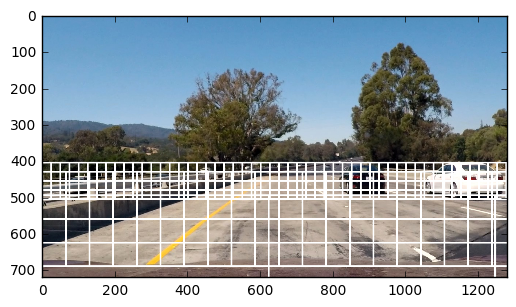

In [75]:
# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
height, width, channels = img.shape
print('height, width, channels = ',height, width, channels)

window_list=();

step_h = 32
start_h = step_h#int(height/4)
stop_h = height 
size_of_sq = int(256 * (1/height))
original_y_val = int(9*height/16) #int(6*height/11)
# original_y_val = int(6*height/12)
y_val = original_y_val
overlap = 0.5
rectangles = []
while y_val<height:
    size_of_sq = int(500000 * (y_val/height) ** 16)
#     size_of_sq = int(3000 * (y_val/height) ** 8)
    window_list = slide_window(img, x_start_stop=[0, width+size_of_sq], y_start_stop=[y_val,y_val+2*size_of_sq], 
                    xy_window=(size_of_sq, size_of_sq), xy_overlap=(overlap,overlap))
    rectangles.extend(window_list)

    y_val = y_val + (1-overlap)*size_of_sq

print("num rectangles = ", len(rectangles))
img = draw_rectangles(img,rectangles)
plt.imshow(img)
plt.show()

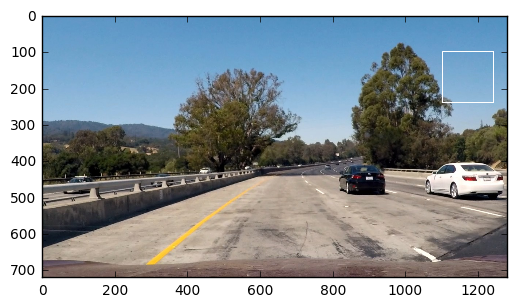

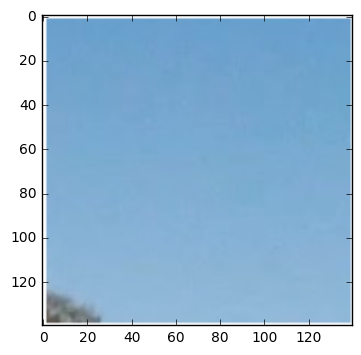

In [83]:
# test on the test_images folder
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (1100,100)
pt2 = (1240,240)
color = (255,255,255)
thickness = 2
cv2.rectangle(img, pt1, pt2, color, thickness)

crop_img = img[pt1[1]:pt2[1], pt1[0]:pt2[0]] # Crop from x, y, w, h -> 100, 200, 300, 400
# NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
# cv2.imshow("cropped", crop_img)
# cv2.waitKey(0)
plt.imshow(img)
plt.show()
plt.imshow(crop_img)
plt.show()

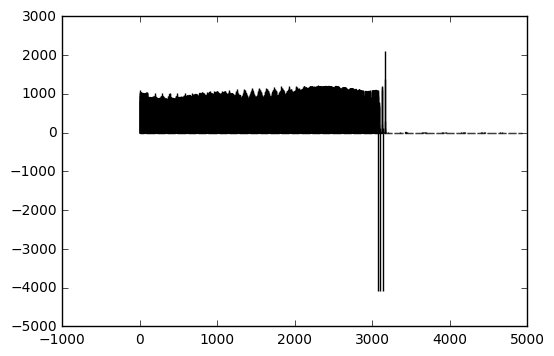

[ 1.]


In [95]:
height, width, channels = crop_img.shape
x_ratio = 32.0/width
y_ratio = 32.0/height
size = (64,64)
crop_img = cv2.resize(crop_img, size)

img_features =[]
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
hog_channel=0
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_features = bin_spatial(crop_img, size=(32,32))
# Apply color_hist() also with a color space option now
hist_features = color_hist(crop_img, nbins=hist_bins, bins_range=hist_range)
# Call get_hog_features() with vis=False, feature_vec=True
hog_features = get_hog_features(crop_img[:,:,hog_channel], orient, 
                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
# Append the new feature vector to the features list
img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))

# Create an array stack of feature vectors
X = np.vstack((img_features)).astype(np.float64)                        

# Apply the scaler to X - normalise data
scaled_X = X_scaler.transform(X)
i = range(len(scaled_X[0]))
plt.bar(i, scaled_X[0], align='center', color='gray')
# cropped = cv2.resize(crop_img, (0,0), x_ratio, y_ratio) 
# plt.imshow(cropped)
plt.show()
prediction = svc.predict(scaled_X.reshape(1, -1))
print(prediction)